In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
cmap = matplotlib.colormaps.get('tab10').colors
from gen_3D_dataset import ThreeDGraphDataset
import torch
import torch_geometric as tg
from tqdm import trange

In [2]:
# Implementation of rotation in case some time needed
from scipy.spatial.transform import Rotation
def rotate_nodes(nodes, angle=np.array([0,0,0])):
    '''
    Rotate nodes by angle in degrees. Angle is a 3D vector with the angles in degrees for each axis, see extrinsic Euler angles.
    '''
    rot_mat = Rotation.from_euler('xyz', angle, degrees=True).as_matrix()
    nodes = np.dot(rot_mat, nodes.T).T
    return nodes

In [3]:
def plot(nodes,cons=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(nodes[:,0], nodes[:,1], nodes[:,2], 'o', color=cmap[0])
    #ax.plot(m_rot[:,0], m_rot[:,1], m_rot[:,2], '+', color=cmap[1])
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    if cons is not None:
        for con in cons.T:
            # This for loop is necessary, 3d plotting is weird.
            ax.plot([nodes[con[0],0], nodes[con[1],0]], [nodes[con[0],1], nodes[con[1],1]], [nodes[con[0],2], nodes[con[1],2]], '-', color=cmap[1])
      
    ax.view_init(6, -80, 0)
    ax.set_aspect('equal')

  0%|          | 0/1400 [00:00<?, ?it/s]c:\Users\steph\OneDrive\Dokumente\VS Code\Python\Computerpraktikum\gen_3D_dataset.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  y          = torch.tensor([label], dtype=torch.float),
100%|██████████| 1400/1400 [00:23<00:00, 59.37it/s]
c:\Users\steph\OneDrive\Dokumente\VS Code\Python\Computerpraktikum\gen_3D_dataset.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fut

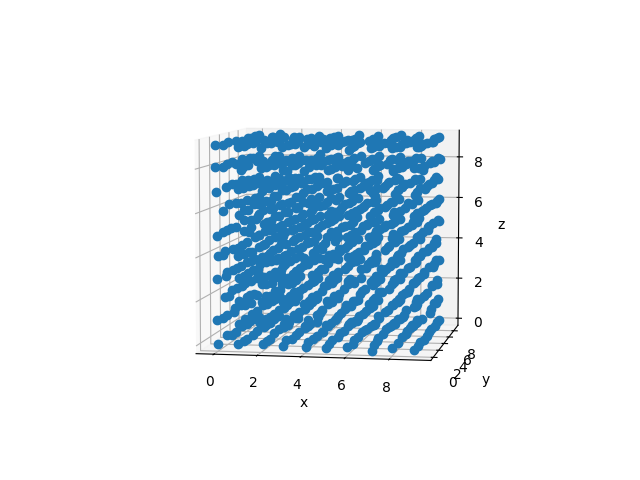

In [4]:
dataset = ThreeDGraphDataset(root='3D_graphs', n_graphs_per_type=100)
dataset.process()
train_loader = tg.loader.DataLoader(dataset[:1100], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[1100:], batch_size=16, shuffle=True)
edges =dataset[11].edge_index
nodes = dataset[11].pos
plot(nodes)

In [ ]:
class GINEConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GINEConv(torch.nn.Linear(dataset.num_features, 10), edge_dim=3)
        self.conv2 = tg.nn.GINEConv(torch.nn.Linear(10, 20), edge_dim=3)
        self.classifier = torch.nn.Linear(20, dataset.num_classes)
    def forward(self, x, edge_index, edge_attr, batch):
        x = torch.tanh(self.conv1(x, edge_index, edge_attr))
        x = torch.tanh(self.conv2(x, edge_index, edge_attr))
        x = tg.nn.global_mean_pool(x, batch)
        out = torch.nn.functional.softmax(self.classifier(x), dim=1)
        
        return out
model2 = GINEConv()
print(model2)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
criterion2 = torch.nn.CrossEntropyLoss()

def train2(loader):
    model2.train()
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)# Perform a single forward pass.
        loss = criterion2(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer2.step()  # Update parameters based on gradients.
        optimizer2.zero_grad() # Reset grads.
def test2(loader):
    model2.eval()
    correct = 0
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

accs = []
acc = test2(test_loader)
accs.append(acc)
for epoch in trange(1, 20):
    train2(train_loader)
    train_acc = test2(train_loader)
    test_acc = test2(test_loader)
    accs.append(test_acc)
    if epoch <5:
        print(f'Epoch: {epoch:03d}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')
plt.plot(accs, label='GINEConv')
plt.legend()
plt.show()


GINEConv(
  (conv1): GINEConv(nn=Linear(in_features=1, out_features=10, bias=True))
  (conv2): GINEConv(nn=Linear(in_features=10, out_features=20, bias=True))
  (classifier): Linear(in_features=20, out_features=14, bias=True)
)


  0%|          | 0/19 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)